# Loading in packages

In [1]:
# # Installing packages
# using Pkg
# Pkg.add(["CairoMakie", "Colors", "CSV", "DataFrames", "GeneticsMakie", "SnpArrays"])

In [3]:
# Loading packages
using CairoMakie, Colors, CSV, DataFrames, GeneticsMakie, SnpArrays, Statistics

# Loading in custom functions

In [4]:
# LDMatrix
mutable struct LDMatrix
    snp_info::AbstractDataFrame
    ld::AbstractMatrix
end

function read_LDMatrix(prefix)
    snp_info = CSV.read(prefix * ".bim", DataFrame;
                        header = ["chromosome", "snpid", "genetic_distance", 
                                  "position", "allele1", "allele2"],
                        types = [String, String, Float64, Int64, String, String])
    ld =
    CSV.File(prefix * ".ld.gz";
             delim = " ", types = Float64, header = 0) |>
    Tables.matrix
    if all(ismissing.(ld[:, end])) && size(ld, 1) + 1 == size(ld, 2)
        ld = ld[:, 1:(end - 1)]
    end
    LDMatrix(snp_info, ld)
end

# plotlocus! code
function setticks(y::Real)
    if y == 10
        return 0:3:10
    elseif 10 < y <= 20
        return 0:5:y
    elseif 20 < y <= 50
        return 0:10:y
    else
        s = div(y, 4)
        d, r = divrem(s, 10)
        return r < 5 ? (0:10d:y) : (0:((d + 1) * 10):y)
    end
end

function calculateld!(
    gwas::DataFrame, 
    ref::SnpData; 
    snp::Union{AbstractString, Tuple{AbstractString, Int}} = "index"
    )

    gwas.ind = GeneticsMakie.findsnps(gwas, ref; matchalleles = false)
    dropmissing!(gwas, "ind")
    n = size(gwas, 1)
    gwas.LD = fill(0.0, n)
    if snp == "index"
        i = argmax(gwas.P)
        snp = gwas.SNP[i]
        geno = convert(Matrix{Float64}, ref.snparray[:, gwas.ind])
        for j in 1:n
            gwas.LD[j] = cor(geno[:, i], geno[:, j])^2    
        end
        gwas.index = fill(snp, n)
        return
    else
        if snp isa AbstractString 
            (chr, bp) = GeneticsMakie.getsnpinfo(snp, ref)
        else 
            (chr, bp) = snp
        end
        i = findfirst((gwas.CHR .== chr) .& (gwas.BP .== bp))
        if isnothing(i)
            snp = ""
            i = findfirst((ref.snp_info.chromosome .== chr) .& (ref.snp_info.position .== bp))
            geno = convert(Matrix{Float64}, ref.snparray[:, [i; gwas.ind]])
            for j in 1:n
                gwas.LD[j] = cor(geno[:, 1], geno[:, j + 1])^2    
            end
        else
            snp = gwas.SNP[i]
            geno = convert(Matrix{Float64}, ref.snparray[:, gwas.ind])
            for j in 1:n
                gwas.LD[j] = cor(geno[:, i], geno[:, j])^2    
            end
        end
        gwas.index = fill(snp, n)
        return
    end
end

function calculateld!(
    gwas::DataFrame, 
    ldmat::LDMatrix; 
    snp::Union{AbstractString, Tuple{AbstractString, Int}} = "index"
    )

    gwas.ind = GeneticsMakie.findsnps(gwas,
                                      select(ldmat.snp_info, :chromosome => :CHR, :position => :BP);
                                      matchalleles = false)
    dropmissing!(gwas, "ind")
    n = size(gwas, 1)
    gwas.LD = fill(0.0, n)
    if snp == "index"
        i = argmax(gwas.P)
        snp = gwas.SNP[i]
        matchedld = ldmat.ld[gwas.ind, gwas.ind]
        for j in 1:n
            gwas.LD[j] = matchedld[i, j]
        end
        gwas.index = fill(snp, n)
        return
    else
        if snp isa AbstractString 
            (chr, bp) = GeneticsMakie.getsnpinfo(snp, ldmat.snp_info.snpid,
                                                 ldmat.snp_info.chromosome,
                                                 ldmat.snp_info.position)
        else 
            (chr, bp) = snp
        end
        i = findfirst((gwas.CHR .== chr) .& (gwas.BP .== bp))
        if isnothing(i)
            snp = ""
            i = findfirst((ref.snp_info.chromosome .== chr) .& (ref.snp_info.position .== bp))
            matchedld = ldmat.ld[gwas.ind, gwas.ind]
            for j in 1:n
                gwas.LD[j] = matchedld[i, j]    
            end
        else
            snp = gwas.SNP[i]
            matchedld = ldmat.ld[gwas.ind, gwas.ind]
            for j in 1:n
                gwas.LD[j] = matchedld[i, j]    
            end
        end
        gwas.index = fill(snp, n)
        return
    end
end

"""
    plotlocus!(ax::Axis, chromosome::AbstractString, range1::Real, range2::Real, gwas::DataFrame; kwargs)
    plotlocus!(ax::Axis, chromosome::AbstractString, bp::Real, gwas::DataFrame; kwargs)
    plotlocus!(ax::Axis, gene::AbstractString, gwas::DataFrame, gencode::DataFrame; kwargs)

Plot `gwas` results within a given `chromosome` and genomic range between `range1` 
and `range2`.

Alternatively, plot within a given `chromosome` and a certain `window` around a 
genomic coordinate `bp` or plot within a certain `window` around `gene`.

# Arguments
- `ld::Union{Nothing, SnpData, AbstractMatrix, Tuple{Union{SnpData, AbstractMatrix}, Union{AbstractString, Tuple{AbstractString, Int}}}} = nothing`: 
    the reference panel for which LD is calculated.
- `ymax::Real`: the maximum value for y axis. 
- `window::Real = 1e6`: the window around `bp` or `gene`. 
"""
function plotlocus!(
    ax::Axis,
    chromosome::AbstractString,
    range1::Real,
    range2::Real,
    gwas::DataFrame;
    ld::Union{Nothing, SnpData, LDMatrix, Tuple{Union{SnpData, LDMatrix}, Union{AbstractString, Tuple{AbstractString, Int}}}} = nothing,
    ymax::Real = 0
    )

    locuszoomcolormap = [colorant"#377fbd",
                         colorant"#45b9da",
                         colorant"#5baf68",
                         colorant"#faa600",
                         colorant"#d43f38"]
    function tofifth(x)
        if ismissing(x) || isnothing(x) || isnan(x)
            return NaN
        elseif x <= 0
            return 1
        elseif x >= 1
            return 5
        else
            return Int64(ceil(x * 5))
        end
    end
    df = filter(x -> (x.CHR == chromosome) && (x.BP >= range1) && (x.BP <= range2), gwas)
    if nrow(df) == 0
        ymax == 0 ? ymax = 10 : nothing
        ax.spinewidth = 0.75
        ax.ytickwidth = 0.75
        ax.ylabelsize = 6
        ax.yticklabelsize = 6
        ax.yticksize = 3
        ax.yticks = setticks(ymax)
        xlims!(ax, range1, range2)
        ylims!(ax, 0, ymax)
        hidespines!(ax, :t, :r)
        hidexdecorations!(ax)
        hideydecorations!(ax, ticks = false, label = false, ticklabels = false)
        return
    end
    df.P = -log.(10, df.P)
    if ymax == 0
        ymax = maximum(df.P) / 4 * 5
        ymax <= 10 ? ymax = 10 : nothing
    end
    if !isnothing(ld)
        typeof(ld) <: Union{SnpData, LDMatrix} ? calculateld!(df, ld) : calculateld!(df, ld[1]; snp = ld[2])
        scatter!(ax, df.BP, df.P, color = tofifth.(df.LD),
            colormap = locuszoomcolormap, markersize = 1.5 * 1.5)
        if typeof(ld) == SnpData
            ind = argmax(df.P)
            bp = df.BP[ind]
            p = df.P[ind]
            scatter!(ax, [bp], [p], color = :purple1, markersize = 4.0 * 1.5, marker = '◆')
            text!(ax, "$(df.index[1])", position = (bp, p), textsize = 6, align = (:center, :bottom))    
        elseif length(df.index[1]) > 0
            ind = findfirst(df.SNP .== df.index[1])
            bp, p = df.BP[ind], df.P[ind]
            scatter!(ax, [bp], [p], color = :purple1, markersize = 4.0 * 1.5, marker = '◆')
            text!(ax, "$(df.index[1])", position = (bp, p), textsize = 6, align = (:center, :bottom))    
        end
    else
        scatter!(ax, df.BP, df.P, color = :gray60, markersize = 1.5 * 1.5)
    end
    ax.spinewidth = 0.75
    ax.ytickwidth = 0.75
    ax.ylabelsize = 6
    ax.yticklabelsize = 6
    ax.yticksize = 3
    ax.yticks = setticks(ymax)
    xlims!(ax, range1, range2)
    ylims!(ax, 0, ymax)
    hidespines!(ax, :t, :r)
    hidexdecorations!(ax)
    hideydecorations!(ax, ticks = false, label = false, ticklabels = false)
end

plotlocus!(ax::Axis, chromosome::AbstractString, bp::Real, gwas::DataFrame; window::Real = 1e6, kwargs...) =
    plotlocus!(ax, chromosome, bp - window, bp + window, gwas; kwargs...)

plotlocus! (generic function with 2 methods)

# Loading in data

The `plotlocus!` function takes in either 1) binary plink files or 2) .bim + .ld.gz file pair to color the SNPs by LD. In the next code block, set the `plinkbfiles` variable to true or false.

In [5]:
plinkbfiles = true

true

In [6]:
# Filenames
pops = ["eur", "amr", "afr", "mixed"]
summarystatsfilenames = [joinpath("/u/project/gandalm/cindywen/isoform_twas/eqtl_new",
                              "locuszoom/MTFR1/$(pop)_ENSG00000066855_all_assoc.txt")
                     for pop in pops]
gencodefilename = joinpath("/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33",
                           "gencode.v33lift37.annotation.gtf")

if plinkbfiles
    genotypefilenames = [joinpath("/u/project/gandalm/cindywen/isoform_twas/genotype",
                                  "all_data/isec_R2_greater_than_3/ancestry/$(pop)",
                                  "filtered.hg19.sorted")
                         for pop in pops]
else
    ldfilenames = [joinpath("/u/project/gandalm/cindywen/isoform_twas/genotype",
                            "ldstore/filtered.hg19.sorted.removeGeneOutlier.chr8:65567919")
                   for pop in pops]
end

mixedgenotypefilename = joinpath("/u/project/gandalm/cindywen/isoform_twas/genotype",
                                 "all_data/isec_R2_greater_than_3/ancestry",
                                 "filtered.hg19.sorted")
genotypefilenames[4] = mixedgenotypefilename

"/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted"

In [7]:
# DataFrames
summarystatsdfs = CSV.read.(summarystatsfilenames, DataFrame;
                            header = ["geneid", "snpid", "distance", "nominal",
                                      "beta", "p"])
gencode = CSV.read(gencodefilename, DataFrame;
                   delim = "\t", comment = "#",
                   header = ["seqnames", "source", "feature", "start", "end", "score", 
                             "strand", "phase", "info"])
GeneticsMakie.parsegtf!(gencode)
select!(gencode,
        :seqnames, :feature, :start, :end, :strand,
        :gene_name, :gene_type, :transcript_id)

,seqnames,feature,start,end,strand,gene_name,gene_type
,String,String15,Int64,Int64,String1,SubStrin…,SubStrin…
1,1,gene,11869,14409,+,DDX11L1,transcribed_unprocessed_pseudogene
2,1,transcript,11869,14409,+,DDX11L1,transcribed_unprocessed_pseudogene
3,1,exon,11869,12227,+,DDX11L1,transcribed_unprocessed_pseudogene
4,1,exon,12613,12721,+,DDX11L1,transcribed_unprocessed_pseudogene
5,1,exon,13221,14409,+,DDX11L1,transcribed_unprocessed_pseudogene
6,1,transcript,12010,13670,+,DDX11L1,transcribed_unprocessed_pseudogene
7,1,exon,12010,12057,+,DDX11L1,transcribed_unprocessed_pseudogene
8,1,exon,12179,12227,+,DDX11L1,transcribed_unprocessed_pseudogene
9,1,exon,12613,12697,+,DDX11L1,transcribed_unprocessed_pseudogene


In [8]:
if plinkbfiles
    # SnpData
    lddata = [SnpData(genof) for genof in genotypefilenames]
else
    # LDMatrix
    lddata = [read_LDMatrix(ldf) for ldf in ldfilenames]
end

4-element Vector{SnpData}:
 SnpData(people: 292, snps: 6381990,
snp_info: 
 Row │ chromosome  snpid        genetic_distance  position  allele1  allele2
     │ String      String       Float64           Int64     String   String
─────┼───────────────────────────────────────────────────────────────────────
   1 │ 1           rs61769339                0.0    662622  A        G
   2 │ 1           rs12238997                0.0    693731  G        A
   3 │ 1           rs61769351                0.0    693823  C        G
   4 │ 1           rs142559957               0.0    704637  A        G
   5 │ 1           rs58276399                0.0    731718  C        T
   6 │ 1           rs61770163                0.0    732032  C        A
…,
person_info: 
 Row │ fid        iid        father     mother     sex        phenotype
     │ Abstract…  Abstract…  Abstract…  Abstract…  Abstract…  Abstract…
─────┼──────────────────────────────────────────────────────────────────
   1 │ 898        898        0    

In [9]:
# Pre-processing data
## Add chromosome and position to summary statistics using plink or LD files

summarystatsdfs = [innerjoin(select(lddata[end].snp_info,
                                    :chromosome, :snpid, :position),
                             df; on = :snpid) for df in summarystatsdfs]
## Munge summary statistics
GeneticsMakie.mungesumstats!(summarystatsdfs)

# Plotting LocusZoom plots

Set the SNP ID you want a plot of in the first cell below

In [10]:
snpid = "rs68167505"

"rs68167505"

In [11]:
# Finding locus
chr = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :chromosome]
start = subset(lddata[end].snp_info,
                    :snpid => col -> col .== snpid)[1, :position]
stop = start
range1 = start - 1e6
range2 = stop + 1e6
n = length(pops)
titles = ["EUR", "AMR", "AFR", "Mixed"]
println(subset(lddata[end].snp_info, :snpid => col -> col .== snpid))


1×6 DataFrame
 Row │ chromosome  snpid       genetic_distance  position  allele1  allele2 
     │ String      String      Float64           Int64     String   String  
─────┼──────────────────────────────────────────────────────────────────────
   1 │ 8           rs68167505               0.0  66557533  C        T


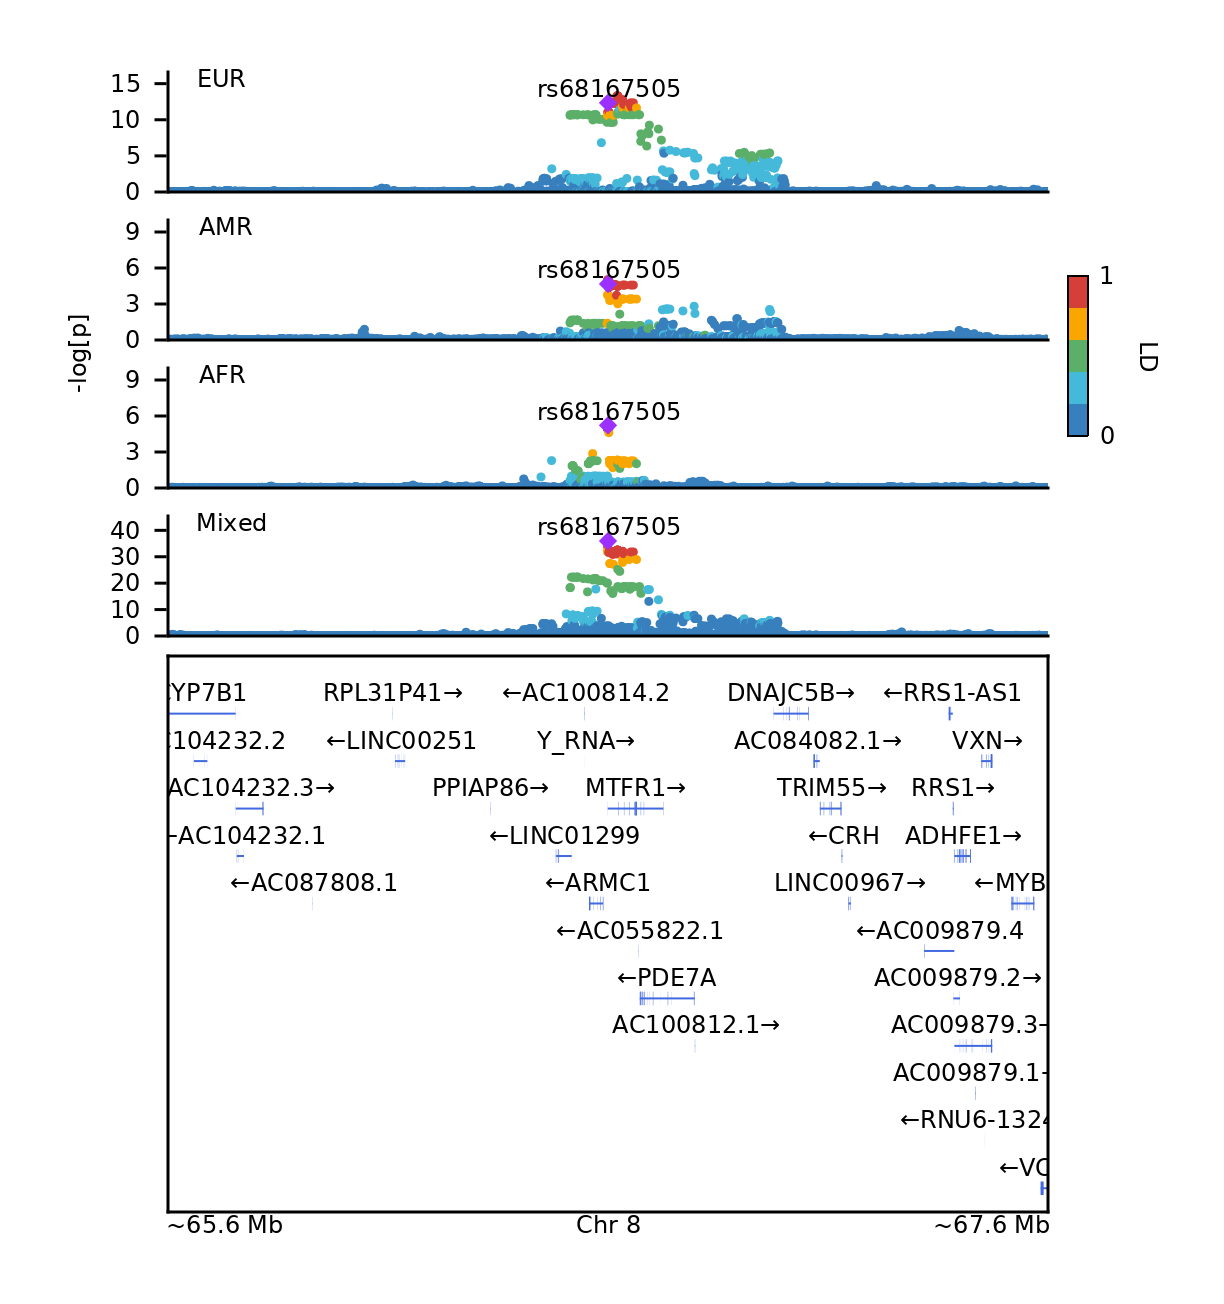

In [12]:
# Plotting locuszoom plots
locuszoomcolormap = [colorant"#377fbd",
                     colorant"#45b9da",
                     colorant"#5baf68",
                     colorant"#faa600",
                     colorant"#d43f38"]
CairoMakie.activate!(type = "png", px_per_unit = 4)
f = Figure(resolution = (306, 792))
axs = [Axis(f[i, 1]) for i in 1:(1 + length(pops))]
for i in 1:n
    if plinkbfiles
        ldfilename = tempname()
        SnpArrays.filter(genotypefilenames[i],
                         1:size(lddata[i].snparray, 1),
                         findall(row -> row.chromosome == chr &&
                                 range1 <= row.position <= range2,
                                 eachrow(lddata[i].snp_info));
                         des = ldfilename)
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (SnpData(ldfilename), snpid))
    else
        plotlocus!(axs[i], chr, range1, range2, summarystatsdfs[i];
           ld = (lddata[i], snpid))
    end
    rowsize!(f.layout, i, 30)
    Label(f[i, 1, Top()], titles[i];
          textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
end
rs = GeneticsMakie.plotgenes!(axs[n + 1], chr, range1, range2, gencode; height = 0.1)
rowsize!(f.layout, n + 1, rs)
GeneticsMakie.labelgenome(f[n + 1, 1, Bottom()], chr, range1, range2)
Colorbar(f[1:n, 2], limits = (0, 1), ticks = 0:1, height = 40,
         colormap = cgrad(locuszoomcolormap, 5, categorical = true), label = "LD", 
         ticksize = 0, tickwidth = 0, tickalign = 0, ticklabelsize = 6,
         flip_vertical_label = true, labelsize = 6, width = 5, spinewidth = 0.5)
Label(f[1:n, 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
rowgap!(f.layout, 5)
colgap!(f.layout, 5)
resize_to_layout!(f)
f

# Save file

Set filename in cell below

In [13]:
CairoMakie.activate!(type = "png")
outputfilename = ""
# save(filename, f, px_per_unit = 4)

""